Radu Vasile Catalin 411 Data Science 

Ex1

1. In the first exercise you will generate a 3D dataset with 500 points using
np.random.multivariate normal function with the mean vector [5, 10,
2] and the covariance matrix [[3, 2, 2], [2, 10, 1], [2, 1, 2]] and plot it
(3D). Then you will perform the PCA steps from the course (center data,
compute covariance matrix, EVD).

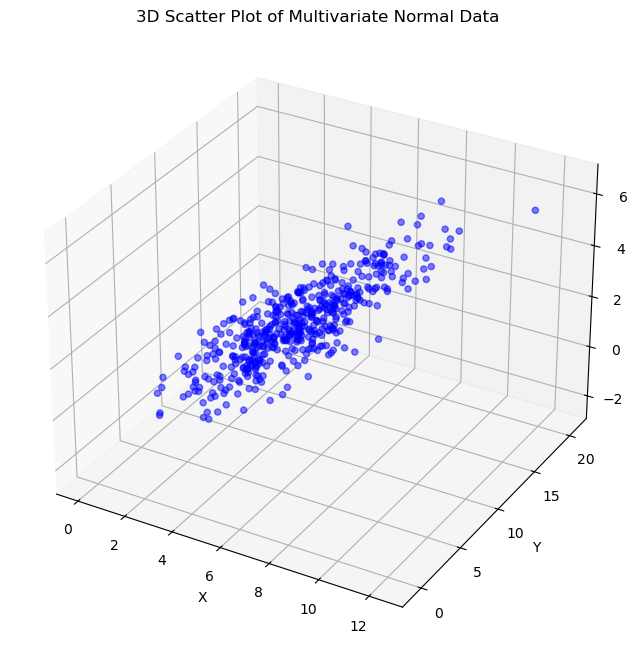

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

SEED = 786
np.random.seed(SEED)
out = np.random.multivariate_normal(
    mean = [5, 10, 2],
    cov = [[3, 2, 2], [2, 10, 1], [2, 1, 2]],
    size = 500
)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(out[:, 0], out[:, 1], out[:, 2], c='blue', marker='o', alpha=0.5)

ax.set_title('3D Scatter Plot of Multivariate Normal Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [12]:
centered_out = out - out.mean(axis=0)
# the rowvar is set to tell cov to consider the columns as values
cov_matrix = np.cov(centered_out, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

2. Plot in the same figure both the cumulative explained variance (computed with the sorted [descending] eigenvalues and the numpy.cumsum
function) with the pyplot.step function and the individual variances (respecting the order) - using the pyplot.bar function.

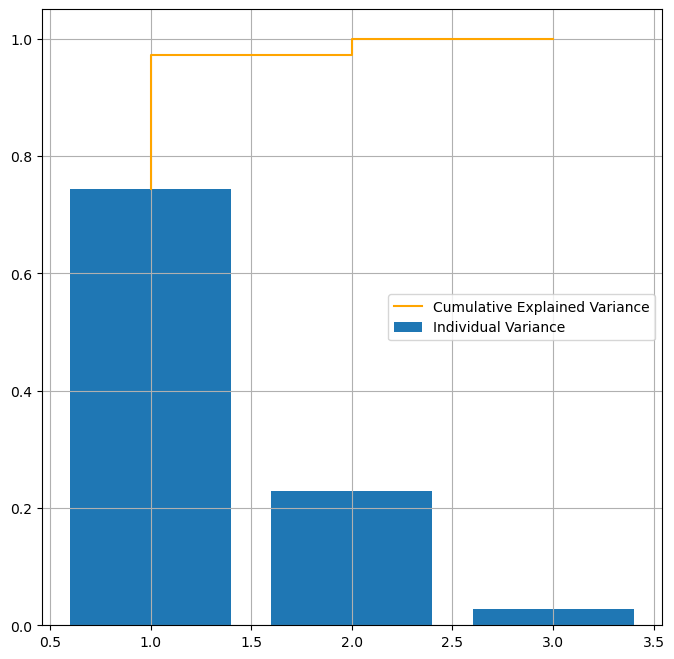

In [13]:
sorted_eigenvalues = np.sort(eigenvalues)[::-1]

#it represents how much each principal component captures from the total variance
cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)
individual_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

plt.figure(figsize=(8, 8))

plt.bar(range(1, len(sorted_eigenvalues) + 1),individual_variance , label='Individual Variance')
plt.step(range(1, len(sorted_eigenvalues) + 1), cumulative_variance, label='Cumulative Explained Variance', color='orange')

plt.legend()
plt.grid(True)

plt.show()

3. Project the data in the new space and identify the outliers based on the deviation of the values over the dimension corresponding to the 3rd principal
component (compared to the mean of all the values of the same component). Use 0.1 as contamination rate and the numpy.quantile function
in order to find the corresponding threshold and predict the labels. Plot
the dataset again (using a different color for points labeled as anomalies).
Repeat the same steps for the second principal component.


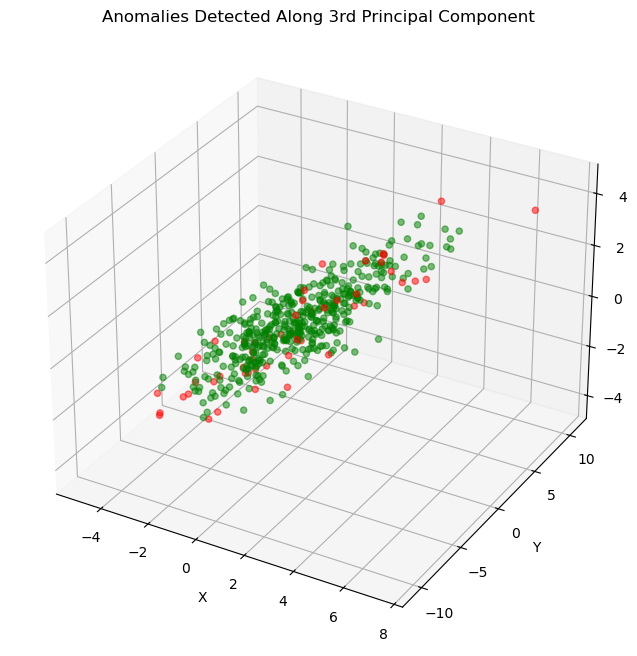

In [14]:
projected_data = centered_out.dot(eigenvectors)

pc3_projection = projected_data[:, 2]
pc3_mean = np.mean(pc3_projection)
pc3_threshold = np.quantile(np.abs(pc3_projection - pc3_mean), 1 - 0.1)
pc3_outliers = np.abs(pc3_projection) > pc3_threshold

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centered_out[:, 0], centered_out[:, 1], centered_out[:, 2], c=np.where(pc3_outliers, 'red', 'green'), marker='o', alpha=0.5)

ax.set_title('Anomalies Detected Along 3rd Principal Component')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

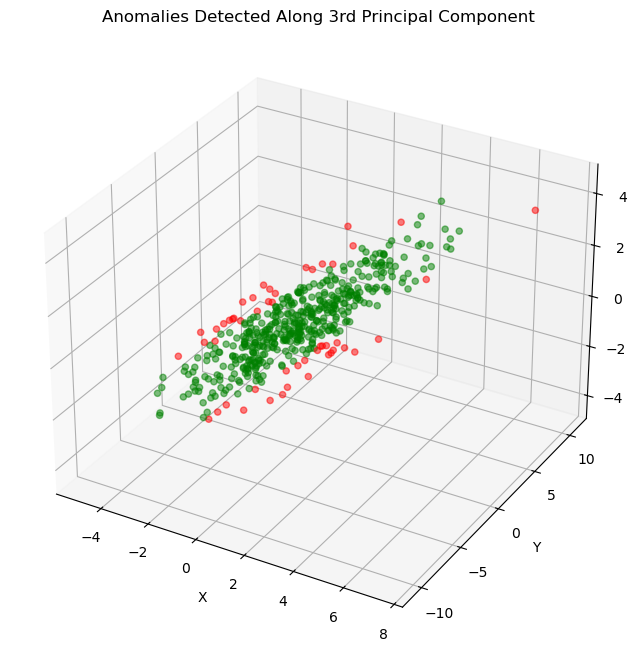

In [15]:
projected_data = centered_out.dot(eigenvectors)

pc2_projection = projected_data[:, 1]
pc2_mean = np.mean(pc2_projection)
pc2_threshold = np.quantile(np.abs(pc2_projection - pc2_mean), 1 - 0.1)
pc2_outliers = np.abs(pc2_projection) > pc2_threshold

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centered_out[:, 0], centered_out[:, 1], centered_out[:, 2], c=np.where(pc2_outliers, 'red', 'green'), marker='o', alpha=0.5)

ax.set_title('Anomalies Detected Along 3rd Principal Component')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

4. Project the data in the new space and identify the outliers based on the
normalized distance (by the corresponding standard deviation) of the data
points to the centroid (in the new space) along all the principal components
(follow the steps from the algorithm in the first part of the lab). Plot the
dataset again (using a different color for points labeled as anomalies)


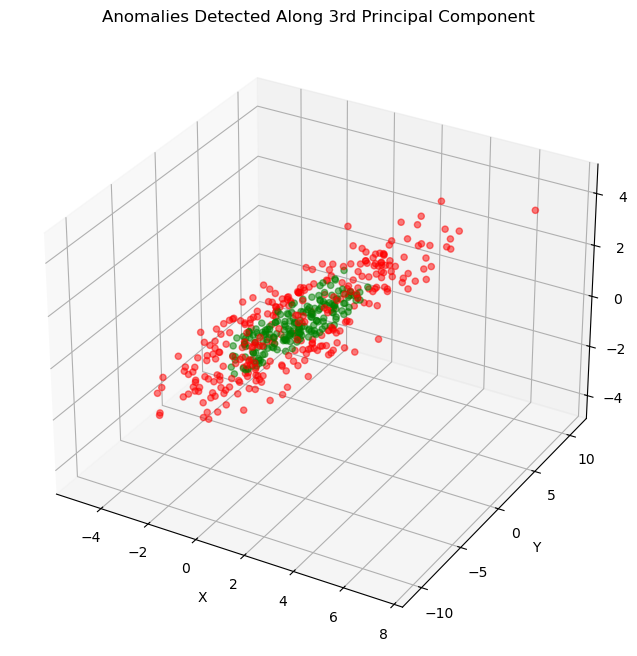

In [16]:
projected_data = centered_out.dot(eigenvectors)
centroid = np.mean(projected_data, axis=0)
std_devs = np.std(projected_data, axis=0)
normalized_distances = np.abs(projected_data - centroid) / std_devs
threshold  = np.quantile(np.linalg.norm(projected_data - centroid, axis=1), 0.9)
outliers = np.any(normalized_distances > pc2_threshold, axis=1)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(centered_out[:, 0], centered_out[:, 1], centered_out[:, 2], c=np.where(outliers, 'red', 'green'), marker='o', alpha=0.5)

ax.set_title('Anomalies Detected Along 3rd Principal Component')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

Ex 2

1. In this exercise you will use the shuttle dataset. Split the data in a training set and a testing set (60% of data). Standardize your data and fit a
pyod.models.pca.PCA model with the training set using the real contamination rate of the training set. Plot the cumulative explained variance
and the individual variances as in the previous exercise (you can access
the variances with the explained variance attribute).

In [17]:
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import  train_test_split
from pyod.models.pca import PCA
from pyod.models.kpca import KPCA
from sklearn.metrics import balanced_accuracy_score

data = loadmat("shuttle.mat")
x = data['X'] 
y = data['y'].ravel() 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.60, 
    random_state=SEED  
)

scaler = StandardScaler()

scaler.fit(x_train)
x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)

In [18]:
# This will calculate the contamination on the train set
contamination_rate = np.sum(y_train == 1) / len(y_train)
pca_model = PCA(contamination=contamination_rate, random_state=SEED)
pca_model.fit(x_train_normalized)

explained_variance_ratio = pca_model.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

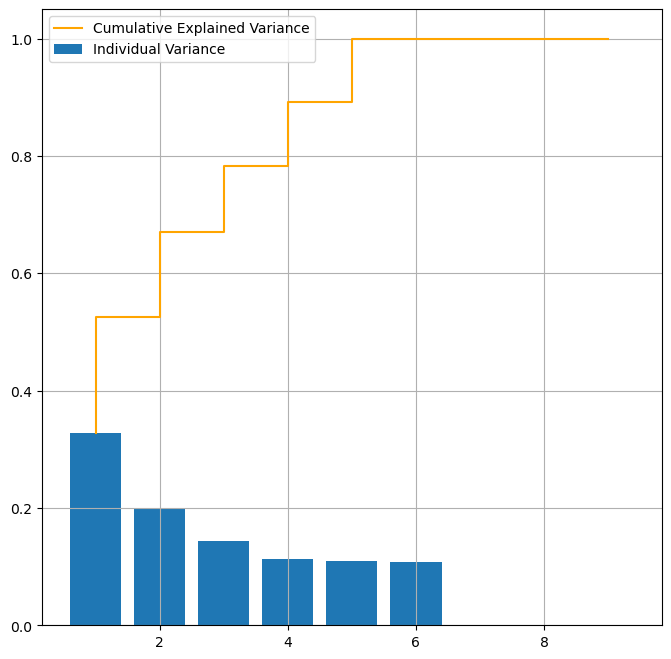

In [19]:
plt.figure(figsize=(8, 8))

plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Individual Variance')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 
         label='Cumulative Explained Variance', color='orange')

plt.legend()
plt.grid(True)
plt.show()

2. Compute the balanced accuracy for both the train and test sets. Then fit
the pyod.models.kpca.KPCA model with the same training data and
compute the scores again

In [ ]:
y_train_pred_pca = pca_model.labels_
y_test_pred_pca = pca_model.predict(x_test_normalized)

print("BA for PCA train:", balanced_accuracy_score(y_train, y_train_pred_pca))
print("BA for PCA test:", balanced_accuracy_score(y_test, y_test_pred_pca))

# KPCA took me too long to run. So I have no output
kpca_model = KPCA(
    contamination=contamination_rate,
    random_state=SEED,
    n_jobs=-1
)
kpca_model.fit(x_train_normalized)

y_train_pred_kpca = kpca_model.labels_
y_test_pred_kpca = kpca_model.predict(x_test_normalized)

print("BA for KPCA train:", balanced_accuracy_score(y_train, y_train_pred_kpca))
print("BA for KPCA test:", balanced_accuracy_score(y_test, y_test_pred_kpca))

BA for PCA train: 0.975312694841375
BA for PCA test: 0.972544557753714


: 

: 

Ex 3


1. In this exercise you will use the shuttle dataset from ODDS. Load the data
using scipy.io.loadmat() and use train test split() to split it into train
and test subsets (use 50% of data for testing). Use min-max normalization
to bring your train data in the [0-1] range.


In [3]:
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  train_test_split
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import balanced_accuracy_score
import numpy as np

data = loadmat("shuttle.mat")
x = data['X'] 
y = data['y'].ravel() 

x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.50, 
    random_state=SEED  
)

scaler = MinMaxScaler()

scaler.fit(x_train)
x_train_normalized = scaler.transform(x_train)
x_test_normalized = scaler.transform(x_test)

2. Design an Autoencoder class that subclasses keras.Model. Use the
keras.Sequential model to create encoder and decoder submodels that
contain only keras.layers.Dense layers. The 2 submodels should contain layers with [8, 5, 3] and [5, 8, 9] output units. Use relu activation
function for each layer except the last one (from the decoder), which will
use sigmoid activation.


In [4]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            Input(shape=(9,)),
            Dense(8, activation='relu'),
            Dense(5, activation='relu'),
            Dense(3, activation='relu')
        ])
        
        self.decoder = Sequential([
            Dense(5, activation='relu'),
            Dense(8, activation='relu'),
            Dense(9, activation='sigmoid')
        ])
        
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

3. Compile your model using adam optimizer and mse loss and fit it with
your training data using 100 epochs and a batch size of 1024 (use the
test data as validation data in the trainig process). Plot the training and
validation loss.

In [5]:
autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train_normalized, 
    x_train_normalized,  
    epochs=100,
    batch_size=1024,
    validation_data=(x_test_normalized, x_test_normalized),
)

Epoch 1/100
24/24 [==============================] - 2s 20ms/step - loss: 0.0236 - val_loss: 0.0212
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0191 - val_loss: 0.0163
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0111
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0038
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 1

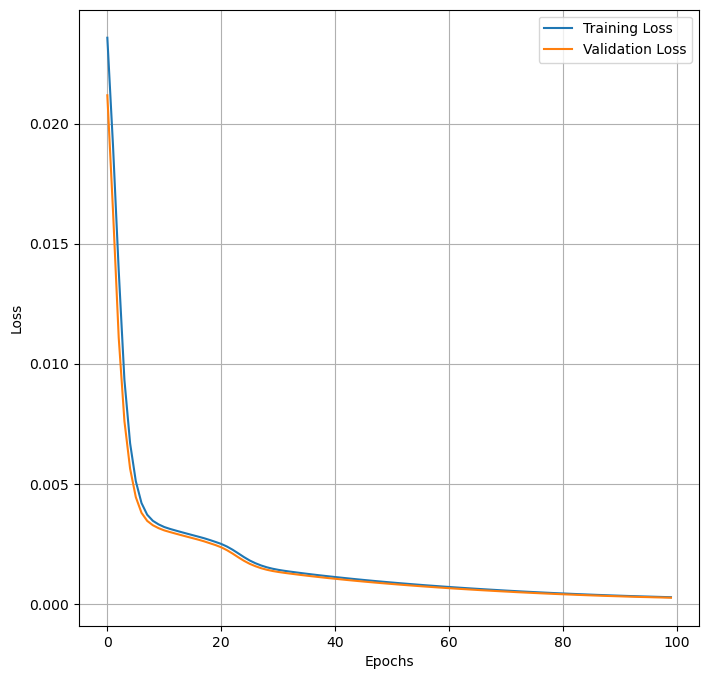

In [6]:
plt.figure(figsize=(8, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

4. In order to obtain the scores for the training data pass it through the
autoencoder and get the reconstruction error for each sample. Compute
a threshold that will be used to classify data with the numpy.quantile
function and the contamination rate of the dataset. Compute the balanced
accuracy for both the training and testing set.

In [7]:
reconstructed_train = autoencoder.predict(x_train_normalized)
reconstructed_test = autoencoder.predict(x_test_normalized)

train_errors = np.mean((x_train_normalized - reconstructed_train) ** 2, axis=1)
test_errors = np.mean((x_test_normalized - reconstructed_test) ** 2, axis=1)

contamination_rate = np.sum(y_train == 1) / len(y_train)
threshold = np.quantile(train_errors, 1 - contamination_rate)

y_train_pred = (train_errors > threshold).astype(int)
y_test_pred = (test_errors > threshold).astype(int)

print("BA train:", balanced_accuracy_score(y_train, y_train_pred))
print("BA test:", balanced_accuracy_score(y_test, y_test_pred))

768/768 [==============================] - 2s 2ms/step
BA train: 0.9393450449694936
BA test: 0.9390590668940262


Ex 4

1. In this exercise we will use the mnist dataset from tensorflow.keras.datasets.mnist.
After you load the dataset with tensorflow.keras.datasets.mnist.load data()
you will normalize it by dividing with 255. In order to simulate anomalies,
you will add some noise to the images with tensorflow.random.normal
(multiplied by a factor of 0.35). You will use tensorflow.clip by value
to keep the range of the pixels [0, 1].


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from sklearn.metrics import accuracy_score

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1) 
x_train_noisy = tf.clip_by_value(x_train + 0.35 * tf.random.normal(shape=x_train.shape), 0, 1)
x_test_noisy = tf.clip_by_value(x_test + 0.35 * tf.random.normal(shape=x_test.shape), 0, 1)

2. Design a Convolutional Autoencoder class that uses the keras.Sequential
model to create encoder and decoder submodels that contain keras.layers.Conv2D
and keras.layers.Conv2DTranspose layers. The encoder will contain:

• 1 Conv2D layer with 8 (3 X 3) filters, relu activation, strides=2 and
padding - ’same’

• 1 Conv2D layer with 4 (3 X 3) filters and the rest of params as
above

The decoder will consist of:

• 1 Conv2DTranspose layer with the same parameters as the last
layer of the encoder

• 1 Conv2DTranspose layer with the same parameters as the first
layer of the encoder

• 1 Conv2D layer with 1 filter with sigmoid activation that will reconstruct the original image

In [9]:
class ConvAutoencoder(Model):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        self.encoder = Sequential([
            Input(shape=(28, 28, 1)),  
            Conv2D(8, (3, 3), activation='relu', strides=2, padding='same'), 
            Conv2D(4, (3, 3), activation='relu', strides=2, padding='same') 
        ])
        
        self.decoder = Sequential([
            Conv2DTranspose(4, (3, 3), activation='relu', strides=2, padding='same'),  # Output: (14, 14, 4)
            Conv2DTranspose(8, (3, 3), activation='relu', strides=2, padding='same'),  # Output: (28, 28, 8)
            Conv2D(1, (3, 3), activation='sigmoid', padding='same')  # Output: (28, 28, 1)
        ])
    
    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


3. Compile your model using adam optimizer and mse loss and fit it with
your training data using 10 epochs and a batch size of 64 (use the test
data as validation data in the trainig process). Use only the original
train data for training. Compute the reconstruction loss for the training
data and a threshold (that will be the mean of the reconstruction errors + their standard deviation). Based on the threshold and the obtained
reconstruction errors classify both the original test images and the ones
that have the added noise (and compute the corresponding accuracy).

In [10]:
autoencoder = ConvAutoencoder()

autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train,  
    x_train,  
    epochs=10,
    batch_size=64,
    validation_data=(x_test, x_test) 
)

Epoch 1/10
938/938 [==============================] - 186s 197ms/step - loss: 0.0315 - val_loss: 0.0062
Epoch 2/10
938/938 [==============================] - 141s 150ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 3/10
938/938 [==============================] - 34s 36ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 4/10
938/938 [==============================] - 47s 51ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 5/10
938/938 [==============================] - 57s 61ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/10
938/938 [==============================] - 89s 95ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 7/10
938/938 [==============================] - 23s 25ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10
938/938 [==============================] - 19s 20ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
938/938 [==============================] - 18s 19ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/10
938/938 [==============================] - 23s 25ms/step - loss: 0

In [11]:
reconstructed_train = autoencoder.predict(x_train)
train_errors = np.mean((x_train - reconstructed_train) ** 2, axis=(1, 2, 3))
threshold = np.mean(train_errors) + np.std(train_errors)
print(f"Threshold: {threshold}")

1875/1875 [==============================] - 6s 3ms/step
Threshold: 0.0031026764772832394


In [12]:
reconstructed_test = autoencoder.predict(x_test)
reconstructed_test_noisy = autoencoder.predict(x_test_noisy)
y_test_pred = (test_errors > threshold).astype(int)

test_errors = np.mean((x_test - reconstructed_test) ** 2, axis=(1, 2, 3))
test_noisy_errors = np.mean((x_test_noisy - reconstructed_test_noisy) ** 2, axis=(1, 2, 3))
y_test_noisy_pred = (test_noisy_errors > threshold).astype(int)


313/313 [==============================] - 1s 3ms/step


In [13]:
# we consider all the noisy one as anomalies
y_test_actual = np.zeros_like(y_test_pred) 
y_test_noisy_actual = np.ones_like(y_test_noisy_pred) 

y_combined_pred = np.concatenate([y_test_pred, y_test_noisy_pred])
y_combined_actual = np.concatenate([y_test_actual, y_test_noisy_actual])

accuracy = accuracy_score(y_combined_actual, y_combined_pred)
print("Accuracy:", accuracy_score(y_combined_actual, y_combined_pred))

Accuracy: 0.9869171321890648


4. Plot in the same figure, on four rows, 5 test images: on the first row -
the original ones, on the second one - the images with the added noise, on
the third, the reconstructed images obtained from the original ones and
on the last row the reconstructed images obtained from the images with
added noise.


1/1 [==============================] - 0s 30ms/step


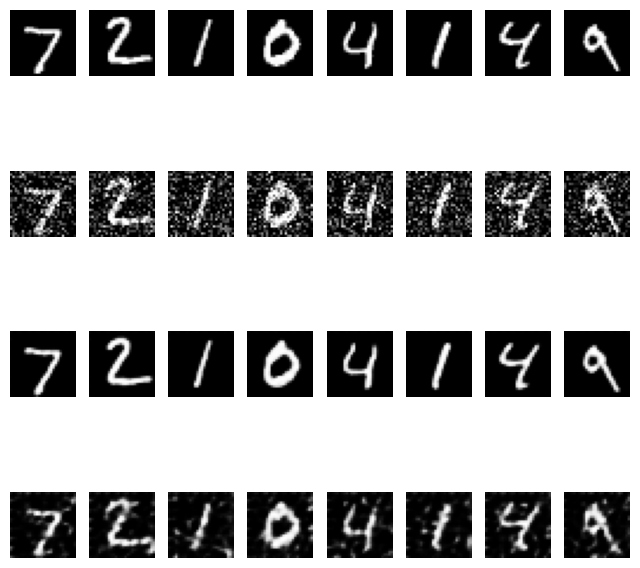

In [14]:
original_images = x_test[:8]
noisy_images = x_test_noisy[:8]
reconstructed_from_original = autoencoder.predict(original_images)
reconstructed_from_noisy = autoencoder.predict(noisy_images)

fig, axes = plt.subplots(4, 8, figsize=(8, 8))

for i in range(8):
    axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel("Original")

for i in range(8):
    axes[1, i].imshow(noisy_images[i].numpy().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel("Noisy")

for i in range(8):
    axes[2, i].imshow(reconstructed_from_original[i].squeeze(), cmap='gray')  # Already a NumPy array
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel("Reconstructed Original")

for i in range(8):
    axes[3, i].imshow(reconstructed_from_noisy[i].squeeze(), cmap='gray')  # Already a NumPy array
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_ylabel("Reconstructed Noisy")

plt.show()


5. Modify the training stage in order to obtain a Denoising Autoencoder and
print the same figure again.


In [15]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    x_train_noisy, 
    x_train,      
    epochs=10,
    batch_size=64,
    validation_data=(x_test_noisy, x_test)  
)


Epoch 1/10
938/938 [==============================] - 18s 19ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 2/10
938/938 [==============================] - 43s 46ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 3/10
938/938 [==============================] - 165s 176ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 5/10
938/938 [==============================] - 110s 118ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 6/10
938/938 [==============================] - 31s 33ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 7/10
938/938 [==============================] - 27s 29ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 8/10
938/938 [==============================] - 22s 24ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 9/10
938/938 [==============================] - 18s 20ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 10/10
938/938 [==============================] - 19s 20ms/step - loss: 0

1/1 [==============================] - 0s 29ms/step


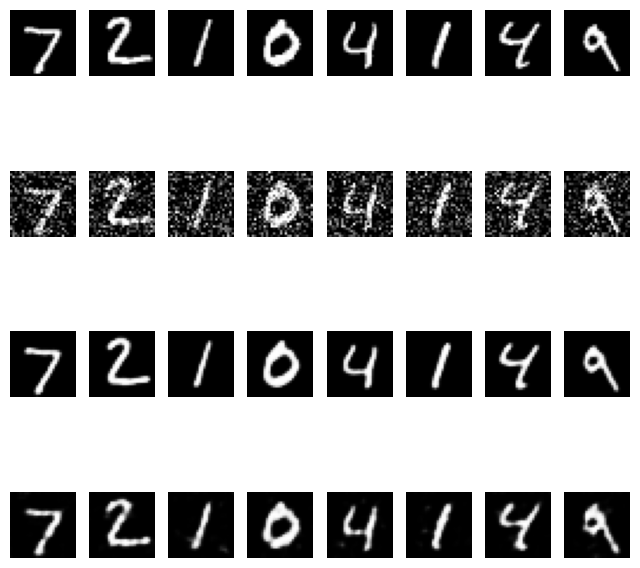

In [16]:
original_images = x_test[:8]
noisy_images = x_test_noisy[:8]
reconstructed_from_original = autoencoder.predict(original_images)
reconstructed_from_noisy = autoencoder.predict(noisy_images)

fig, axes = plt.subplots(4, 8, figsize=(8, 8))

for i in range(8):
    axes[0, i].imshow(original_images[i].squeeze(), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel("Original")

for i in range(8):
    axes[1, i].imshow(noisy_images[i].numpy().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel("Noisy")

for i in range(8):
    axes[2, i].imshow(reconstructed_from_original[i].squeeze(), cmap='gray')  # Already a NumPy array
    axes[2, i].axis('off')
    if i == 0:
        axes[2, i].set_ylabel("Reconstructed Original")

for i in range(8):
    axes[3, i].imshow(reconstructed_from_noisy[i].squeeze(), cmap='gray')  # Already a NumPy array
    axes[3, i].axis('off')
    if i == 0:
        axes[3, i].set_ylabel("Reconstructed Noisy")

plt.show()
